# Systems Biology Informed Neural Network

We aim to reimplement the SBINN from the article _Systems Biology: Identifiability analysis and parameter
identification via systems-biology informed neural networks_, M. Daneker et al., 2023, [link](https://arxiv.org/pdf/2202.01723.pdf). This is a `jinns` adaptation of the [code](https://github.com/lu-group/sbinn) accompanying the article. Results are discussed [here](https://github.com/lu-group/sbinn/issues/4).

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Import our package

In [2]:
import jinns

Import other dependencies

In [3]:
import jax
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx
import numpy as np
import matplotlib.pyplot as plt

key = random.PRNGKey(2)
key, subkey = random.split(key)

# Load the observed data

In [4]:
gluc_data = np.hsplit(np.loadtxt("sbinn_data/glucose.dat"), [1])
data_t = gluc_data[0]
data_y = gluc_data[1]

# Creation of a large SystemLoss in `jinns`

## 1. Create the datagenerators objects

In [5]:
nt = int(2**12)
batch_size = 256
method = "uniform"
tmin = 0
tmax = 1800

Tmax = 1
key, subkey = random.split(key)
train_data = jinns.data.DataGeneratorODE(
    key=subkey,
    nt=nt,
    tmin=tmin,
    tmax=tmax,
    temporal_batch_size=batch_size,
    method=method,
)

n = 1800
key, subkey = random.split(key)
idx = jnp.append(
    jax.random.choice(subkey, jnp.arange(1, n - 1), shape=(n // 5,), replace=False),
    jnp.array([0, n - 1]),
)


key, subkey = random.split(key)
obs_batch_size = 256  # must be equal to time_batch_size !
obs_data = jinns.data.DataGeneratorObservations(
    obs_batch_size=obs_batch_size,
    observed_pinn_in=data_t[idx].squeeze() / Tmax,
    observed_values=data_y[idx, 2],
    key=subkey,
)

## 2 Create the neural networks

The following cells create 6 neural networks for the 6 outputs we are trying 
to predict.

**Important:** both the input (feature) `t` and the ouput of the network change in this 
example. To do this, we use the `input_transform` and `output_transform`
functionnalities of the PINN creation. Below we define the transformation as 
described in the original work we are trying to reproduce.

In [6]:
eqx_list = (
    (eqx.nn.Linear, 6, 40),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 40, 40),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 40, 40),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 40, 40),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 40, 40),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 40, 6),
)


def feature_transform(t, params):
    """
    NOTE: t and params are mandatory parameters for an `input_transform`
    function in jinns.

    Here, the params are not used, but it could.
    """
    t = 0.01 * t
    return jnp.concatenate(
        [t, jnp.sin(t), jnp.sin(2 * t), jnp.sin(3 * t), jnp.sin(4 * t), jnp.sin(5 * t)],
        axis=0,
    )


def output_transform(t, y, params):
    idx = 1799
    t = t.squeeze() * 1
    k = (data_y[idx, :] - data_y[0, :]) / (data_t[idx] - data_t[0])
    b = (data_t[idx] * data_y[0, :] - data_t[0] * data_y[idx, :]) / (
        data_t[idx] - data_t[0]
    )
    linear = k.squeeze() * t + b.squeeze()
    factor = jnp.tanh(t) * jnp.tanh(idx - t)

    return linear + factor * jnp.array([1, 1, 1e2, 1, 1, 1]) * y

In [7]:
u, init_nn_params = jinns.nn.PINN_MLP.create(
    key=subkey,
    eqx_list=eqx_list,
    eq_type="ODE",
    input_transform=feature_transform,
    output_transform=output_transform,
)

## 3. Create the two dictionnaries of `nn_params` and `eq_params` used in the system

In [8]:
def get_variable(v, var):
    # defined by the authors of the original work
    low, up = v * 0.2, v * 1.8
    l = (up - low) / 2
    v1 = l * jnp.tanh(var) + l + low
    return v1


E_ = 0.0
tp_ = 0.0
ti_ = 0.0
td_ = 0.0
k_ = 0.0
Rm_ = 0.0
a1_ = 0.0
C1_ = 0.0
C2_ = 0.0
C4_ = 0.0
C5_ = 0.0
Ub_ = 0.0
U0_ = 0.0
Um_ = 0.0
Rg_ = 0.0
alpha_ = 0.0
beta_ = 0.0

# This is the actual data we have for some equation parameters
meal_data = jnp.hsplit(np.loadtxt("sbinn_data/meal.dat"), [4])
meal_t = meal_data[0].astype(float) / Tmax
meal_q = meal_data[1].astype(float)

In [9]:
init_params = jinns.parameters.Params(
    nn_params=init_nn_params,
    eq_params={
        "Vp": 3.0,
        "Vi": 11.0,
        "Vg": 10.0,
        "E": (jnp.tanh(E_) + 1) * 0.1 + 0.1,
        "tp": (jnp.tanh(tp_) + 1) * 2 + 4,
        "ti": (jnp.tanh(ti_) + 1) * 40 + 60,
        "td": (jnp.tanh(td_) + 1) * 25 / 6 + 25 / 3,
        "k": get_variable(0.0083, k_),
        "Rm": get_variable(209 / 100, Rm_),
        "a1": get_variable(6.6, a1_),
        "C1": get_variable(300 / 100, C1_),
        "C2": get_variable(144 / 100, C2_),
        "C3": 100 / 100,
        "C4": get_variable(80 / 100, C4_),
        "C5": get_variable(26 / 100, C5_),
        "Ub": get_variable(72 / 100, Ub_),
        "U0": get_variable(4 / 100, U0_),
        "Um": get_variable(90 / 100, Um_),
        "Rg": get_variable(180 / 100, Rg_),
        "alpha": get_variable(7.5, alpha_),
        "beta": get_variable(1.772, beta_),
        "meal_t": jnp.asarray(meal_t),
        "meal_q": jnp.asarray(meal_q),
    },
)

## 4. Implement a vectorial `DynamicLoss` for the six equations

For this, we subclass the `jinns.loss.ODE` Module pre-defined in **jinns**.

We need to defined an order for the output of the PINN. Let's say we have `[Ip, Ii, G, h1, h2, h3]`

In [10]:
from jinns.loss._DynamicLossAbstract import ODE
from jinns.parameters import Params
from jaxtyping import Array, Float


class SBINN(ODE):
    def equation(
        self,
        t: Float[Array, "1"],
        u: eqx.Module,
        params: Params,
    ) -> Float[Array, "6"]:
        eq_params = params.eq_params
        Ip, dIp_dt = jax.value_and_grad(lambda t: u(t, params)[0], 0)(t)
        Ii, dIi_dt = jax.value_and_grad(lambda t: u(t, params)[1], 0)(t)
        G, dG_dt = jax.value_and_grad(lambda t: u(t, params)[2], 0)(t)
        h1, dh1_dt = jax.value_and_grad(lambda t: u(t, params)[3], 0)(t)
        h2, dh2_dt = jax.value_and_grad(lambda t: u(t, params)[4], 0)(t)
        h3, dh3_dt = jax.value_and_grad(lambda t: u(t, params)[5], 0)(t)

        f1 = eq_params["Rm"] * jax.nn.sigmoid(
            G / (eq_params["Vg"] * eq_params["C1"]) - eq_params["a1"]
        )
        tmp = eq_params["E"] * (Ip / eq_params["Vp"] - Ii / eq_params["Vi"])

        f2 = eq_params["Ub"] * (1 - jnp.exp(-G / (eq_params["Vg"] * eq_params["C2"])))
        kappa = (
            1 / eq_params["Vi"] + 1 / (eq_params["E"] * eq_params["ti"])
        ) / eq_params["C4"]
        f3 = (
            eq_params["U0"]
            + eq_params["Um"]
            / (1 + jnp.power(jnp.maximum(kappa * Ii, (1e-3)), -eq_params["beta"]))
        ) / (eq_params["Vg"] * eq_params["C3"])
        f4 = eq_params["Rg"] * jax.nn.sigmoid(
            eq_params["alpha"] * (1 - h3 / (eq_params["Vp"] * eq_params["C5"]))
        )
        dt = Tmax * (t - eq_params["meal_t"])
        IG = jnp.sum(
            0.5
            * eq_params["meal_q"]
            * eq_params["k"]
            * jnp.exp(-eq_params["k"] * dt)
            * (jnp.sign(dt) + 1)
        )

        return jnp.array(
            [
                dIi_dt + self.Tmax * (-(tmp - Ii / eq_params["ti"])),
                dIp_dt + self.Tmax * (-(f1 - tmp - Ip / eq_params["tp"])),
                dG_dt + self.Tmax * (-(f4 + IG - f2 - f3 * G)),
                dh1_dt + self.Tmax * (-(Ip - h1) / eq_params["td"]),
                dh2_dt + self.Tmax * (-(h1 - h2) / eq_params["td"]),
                dh3_dt + self.Tmax * (-(h2 - h3) / eq_params["td"]),
            ]
        )


sbinn = SBINN(Tmax=Tmax)

## 5. Create the system of equations with `SystemLossODE`

In [11]:
# as in the original article we first train only with the data fitting part of the loss
loss_weights = jinns.loss.LossWeightsODE(
    dyn_loss=0,
    observations=1e-2,
)

loss = jinns.loss.LossODE(
    u=u,
    loss_weights=loss_weights,
    dynamic_loss=sbinn,
    initial_condition=None,
    params=init_params,
    obs_slice=jnp.s_[2:3],
)

/home/hugo/Documents/recherche/pinn/gitlab/jinns/loss/_LossODE.py:100: UserWarning: Initial condition wasn't provided. Be sure to cover for thatcase (e.g by. hardcoding it into the PINN output).
  warnings.warn(


In [21]:
from jinns.data import append_obs_batch

# Testing the loss function
losses_and_grad = jax.value_and_grad(loss.evaluate, 0, has_aux=True)
losses, grads = losses_and_grad(
    init_params, append_obs_batch(train_data.get_batch()[1], obs_data.get_batch()[1])
)
l_tot, d = losses
print(f"total loss: {l_tot}")
print(f"Individual losses: { {key: f'{val:.2f}' for key, val in d.items()} }")

total loss: 32579.744140625
Individual losses: {'dyn_loss': '141262.88', 'observations': '3257974.50'}


## Start training : 10000 iterations on pure data first and then on full loss

The value of hyper-parameters are taken from Figure 12 of [the SBINN article](https://arxiv.org/pdf/2202.01723.pdf).

In [22]:
params = init_params

In [23]:
# Optimizer
import optax

tx = optax.adam(learning_rate=1e-3)
n_iter = int(10000)

In [25]:
key, subkey = random.split(key)
params, total_loss_list, loss_by_term_dict, train_data, loss, opt_state, _, _, _, _ = (
    jinns.solve(
        n_iter=n_iter,
        init_params=params,
        data=train_data,
        loss=loss,
        obs_data=obs_data,
        optimizer=tx,
    )
)


Compilation took
 8.288516998291016 

[train] Iteration 0: loss value = 31411.2890625
[train] Iteration 1000: loss value = 3363.536376953125
[train] Iteration 2000: loss value = 1160.0086669921875
[train] Iteration 3000: loss value = 731.532470703125
[train] Iteration 4000: loss value = 279.0355529785156
[train] Iteration 5000: loss value = 298.1671142578125
[train] Iteration 6000: loss value = 104.8026351928711
[train] Iteration 7000: loss value = 87.90757751464844
[train] Iteration 8000: loss value = 61.16431427001953
[train] Iteration 9000: loss value = 190.08580017089844

Stopping main optimization loop, cause: max iteration is reached

Training took
 22.177208423614502 


Final iteration 10000: train loss value = 29.601049423217773


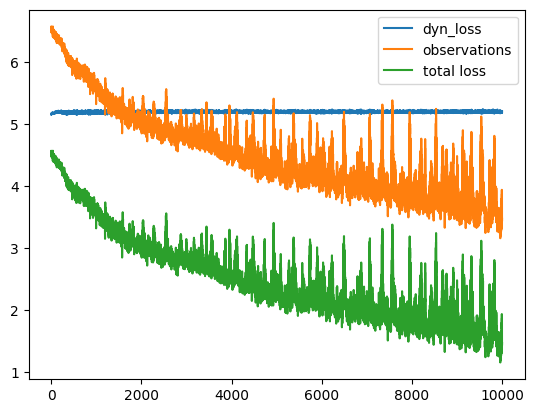

In [26]:
for loss_name, loss_values in loss_by_term_dict.items():
    #     if loss_name == "dyn_loss":
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show();

In [30]:
# And then we reintroduce the dynamic loss and ponderate each dimensions of the DynamicLoss
alpha = 1
loss_weights = jinns.loss.LossWeightsODE(
    dyn_loss=1,
    observations=1e-2,
)
sbinn = SBINN(
    Tmax=Tmax,
    vectorial_dyn_loss_ponderation=jnp.array(
        [alpha, alpha, alpha * 1e-2, alpha, alpha, alpha]
    ),
)

loss = jinns.loss.LossODE(
    u=u,
    loss_weights=loss_weights,
    dynamic_loss=sbinn,
    initial_condition=None,
    params=init_params,
    obs_slice=jnp.s_[2:3],
)

In [31]:
n_iter = int(30000)

In [32]:
# Optimizer
import optax

tx = optax.adam(learning_rate=1e-3)
key, subkey = random.split(key)
params, total_loss_list, loss_by_term_dict, train_data, loss, opt_state, _, _, _, _ = (
    jinns.solve(
        n_iter=n_iter,
        init_params=params,
        data=train_data,
        loss=loss,
        obs_data=obs_data,
        optimizer=tx,
        opt_state=opt_state,
    )
)


Compilation took
 8.505894422531128 

[train] Iteration 0: loss value = 777170.125
[train] Iteration 1000: loss value = 107084.953125
[train] Iteration 2000: loss value = 22831.078125
[train] Iteration 3000: loss value = 17869.302734375
[train] Iteration 4000: loss value = 15901.2587890625
[train] Iteration 5000: loss value = 16584.40625
[train] Iteration 6000: loss value = 18592.37109375
[train] Iteration 7000: loss value = 10165.2783203125
[train] Iteration 8000: loss value = 12364.9541015625
[train] Iteration 9000: loss value = 16053.5419921875
[train] Iteration 10000: loss value = 11086.263671875
[train] Iteration 11000: loss value = 8601.791015625
[train] Iteration 12000: loss value = 11299.529296875
[train] Iteration 13000: loss value = 9513.1171875
[train] Iteration 14000: loss value = 9250.041015625
[train] Iteration 15000: loss value = 8837.779296875
[train] Iteration 16000: loss value = 7007.8408203125
[train] Iteration 17000: loss value = 7680.41015625
[train] Iteration 180

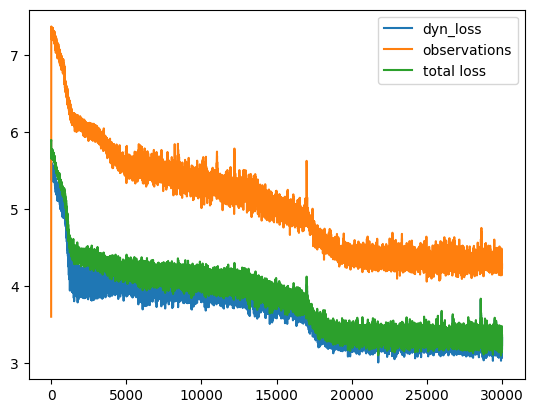

In [33]:
for loss_name, loss_values in loss_by_term_dict.items():
    #     if loss_name == "dyn_loss":
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show();

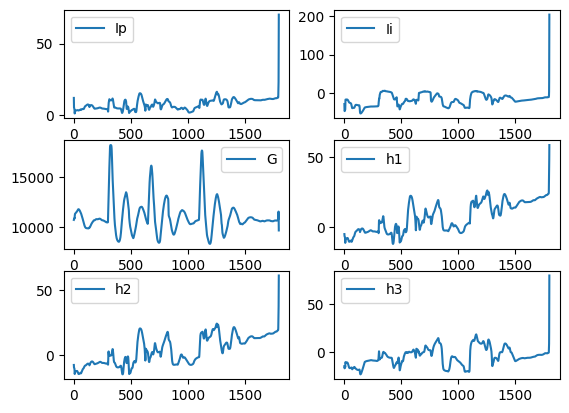

In [34]:
u_est_Ip = vmap(lambda t: u(t, params["nn_params"])[0], (0), 0)
u_est_Ii = vmap(lambda t: u(t, params["nn_params"])[1], (0), 0)
u_est_G = vmap(lambda t: u(t, params["nn_params"])[2], (0), 0)
u_est_h1 = vmap(lambda t: u(t, params["nn_params"])[3], (0), 0)
u_est_h2 = vmap(lambda t: u(t, params["nn_params"])[4], (0), 0)
u_est_h3 = vmap(lambda t: u(t, params["nn_params"])[5], (0), 0)

key, subkey = random.split(key, 2)
val_data = jinns.data.DataGeneratorODE(
    key=subkey,
    nt=nt,
    tmin=tmin,
    tmax=tmax,
    temporal_batch_size=batch_size,
    method=method,
)

fig, axes = plt.subplots(3, 2)
labels = ["Ip", "Ii", "G", "h1", "h2", "h3"]
for i in range(3):
    for j in range(2):
        idx = jnp.ravel_multi_index((i, j), (3, 2))
        u_est_ij = vmap(lambda t: u(t, params)[idx], 0, 0)
        axes[i, j].plot(
            val_data.times.sort(axis=0) * Tmax,
            u_est_ij(val_data.times.sort(axis=0)),
            label=labels[idx],
        )
        axes[i, j].legend()

## Compare with the scipy solver

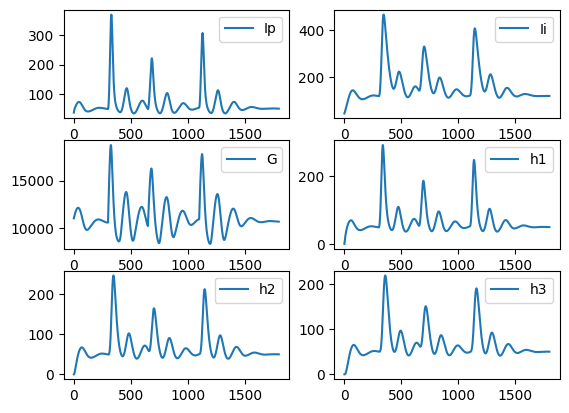

In [35]:
import numpy as np
from scipy.integrate import odeint


def glucose_insulin_model(
    t,
    meal_t,
    meal_q,
    Vp=3,
    Vi=11,
    Vg=10,
    E=0.2,
    tp=6,
    ti=100,
    td=12,
    k=1 / 120,
    Rm=209,
    a1=6.6,
    C1=300,
    C2=144,
    C3=100,
    C4=80,
    C5=26,
    Ub=72,
    U0=4,
    Um=90,
    Rg=180,
    alpha=7.5,
    beta=1.772,
):
    def func(y, t):
        f1 = Rm / (1 + np.exp(-y[2] / Vg / C1 + a1))
        f2 = Ub * (1 - np.exp(-y[2] / Vg / C2))
        kappa = (1 / Vi + 1 / E / ti) / C4
        f3 = (U0 + Um / (1 + (kappa * y[1]) ** (-beta))) / Vg / C3
        f4 = Rg / (1 + np.exp(alpha * (y[5] / Vp / C5 - 1)))
        IG = np.sum(
            meal_q
            * k
            * np.exp(Tmax * k * (meal_t - t))
            * np.heaviside(Tmax * (t - meal_t), 0.5)
        )
        tmp = E * (y[0] / Vp - y[1] / Vi)
        return [
            Tmax * (f1 - tmp - y[0] / tp),
            Tmax * (tmp - y[1] / ti),
            Tmax * (f4 + IG - f2 - f3 * y[2]),
            Tmax * ((y[0] - y[3]) / td),
            Tmax * ((y[3] - y[4]) / td),
            Tmax * ((y[4] - y[5]) / td),
        ]

    Vp0, Vi0, Vg0 = 3, 11, 10
    y0 = [12 * Vp0, 4 * Vi0, 110 * Vg0**2, 0, 0, 0]
    return odeint(func, y0, t)


meal_t = np.array([300, 650, 1100, 2000]) / Tmax
meal_q = np.array([60e3, 40e3, 50e3, 100e3])
t = np.arange(0, 1800, 1)[:, None] / Tmax
y = glucose_insulin_model(np.ravel(t), meal_t, meal_q)

fig, axes = plt.subplots(3, 2)
labels = ["Ip", "Ii", "G", "h1", "h2", "h3"]
for i in range(3):
    for j in range(2):
        idx = jnp.ravel_multi_index((i, j), (3, 2))
        axes[i, j].plot(t * Tmax, y[:, idx], label=labels[idx])
        axes[i, j].legend()

Results are discussed [here](https://github.com/lu-group/sbinn/issues/4).